# Segmenting and counting words in Chinese museum names

Let's reproduce part of [this piece from Caixin](https://datanews.caixin.com/mobile/museum/), where the names of Chinese museums are segmented out and the most popular words are counted.

<p class="reading-options">
  <a class="btn" href="/caixin-museum-word-count/counting-words-in-chinese-museum-names">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/caixin-museum-word-count/notebooks/Counting words in Chinese museum names.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **museums.csv:** raw museums - The raw list of museums, as exported by Tabula


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/caixin-museum-word-count/data/museums.csv -P data

## Setup

There's actually a fair bit of setup in this reproduction. We'll need to install [jieba](https://github.com/fxsjy/jieba), a text segmentation library for Chinese, as well as set up some matplotlib graphing options so that Chinese characters display correctly.

In [1]:
# Use pip to install jieba, a Chinese text-segmentation library
#!pip install jieba

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# So Chinese characters can appear correctly
plt.rcParams['font.sans-serif'] = ['SimHei', 'SimSun', 'Microsoft YaHei New', 'Microsoft YaHei', 'Arial Unicode MS']

## Our target

We'll be aiming to reproduce this graphic specifically - we won't use a word cloud, but we'll try to get counts for each word used in the museum names.

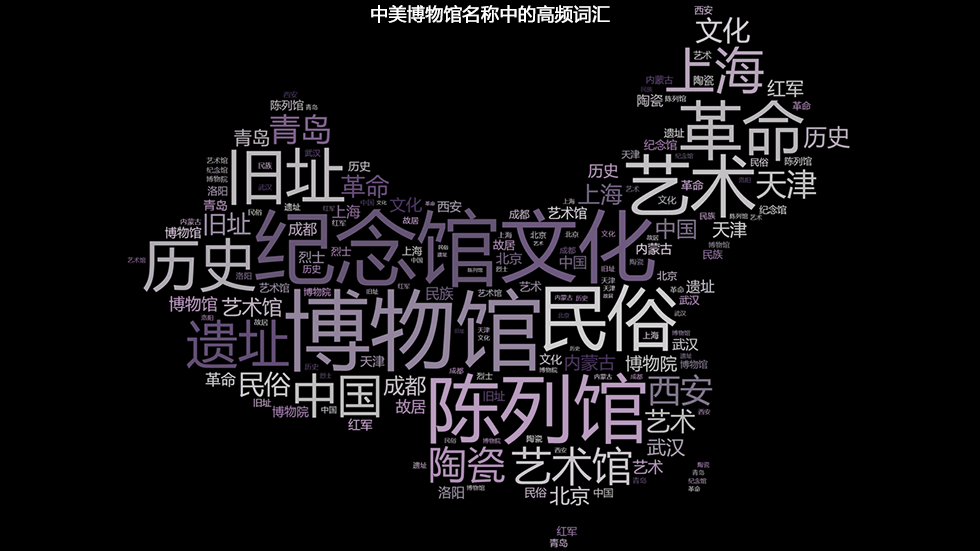

# Our dataset

We'll start off by reading in our cleaned dataset of museums. Nothing too crazy going on yet!

In [3]:
df = pd.read_csv("data/museums-cleaned.csv")
df.head()

,博物馆名称,博物馆性质,质量等级,是否免费开放,地址,region
0,故宫博物院,文物,一级,否,东城区景山前街4号,北京市
1,中国国家博物馆,文物,一级,是,北京市东城区东长安街16号,北京市
2,中国人民革命军事博物馆,行业,一级,是,海淀区复兴路9号,北京市
3,北京鲁迅博物馆(北京新文化运动\r纪念馆),文物,一级,是,阜成门内宫门口二条19号\r东城区五四大街29号,北京市
4,中国地质博物馆,行业,一级,否,西城区西四羊肉胡同15号,北京市


And how many museums are in our dataset?

In [5]:
df.shape

(4469, 6)

While we have a handful of columns here, we're only interested in **博物馆名称**, the museum name.

## Cleaning museum names

If we wanted to analyze each museum separately we could start from here, but we want to talk about **all of the words used in all of the museum names**. To do that, we'll need all of our names in **one string**.

Let's combine all of the museum names, putting spaces in between each name.

In [100]:
museum_names = ' '.join(df.博物馆名称)
museum_names[:400]

'故宫博物院 中国国家博物馆 中国人民革命军事博物馆 北京鲁迅博物馆(北京新文化运动\r纪念馆) 中国地质博物馆 中国农业博物馆 中国人民抗日战争纪念馆 中国科学技术馆 北京自然博物馆 首都博物馆 周口店北京人遗址博物馆 中国航空博物馆 北京天文馆(北京古观象台) 大钟寺古钟博物馆 北京古代建筑博物馆 中国电信博物馆 中国铁道博物馆 孔庙国子监博物馆 明十三陵博物馆 恭王府博物馆 北京石刻艺术博物馆 中国长城博物馆 北京西周燕都遗址博物馆 北京大葆台西汉墓博物馆 詹天佑纪念馆 北京文博交流馆 北京民俗博物馆 中国美术馆 毛主席纪念堂 民族文化宫博物馆 中国古动物馆 宋庆龄故居 北京艺术博物馆 中国邮政邮票博物馆 郭沫若纪念馆 梅兰芳纪念馆 中国佛教图书文物馆 雍和宫藏传佛教艺术博物馆 北京古代钱币博物馆 北京大学赛克勒考古与艺术博物馆 北京市白塔寺 李大钊烈士陵园 焦庄户地道战遗址纪念馆 中央'

Notice that there are some characters in there that are **not word-related** - things like `(` and `\\r` and `)`.

To remove all non-word-related characters, we'll use a regular expression. Our regex will be `[^\w]`, which means "match everything that is not a word character."

In [101]:
museum_names = re.sub('[^\w]', ' ', museum_names)
museum_names[:400]

'故宫博物院 中国国家博物馆 中国人民革命军事博物馆 北京鲁迅博物馆 北京新文化运动 纪念馆  中国地质博物馆 中国农业博物馆 中国人民抗日战争纪念馆 中国科学技术馆 北京自然博物馆 首都博物馆 周口店北京人遗址博物馆 中国航空博物馆 北京天文馆 北京古观象台  大钟寺古钟博物馆 北京古代建筑博物馆 中国电信博物馆 中国铁道博物馆 孔庙国子监博物馆 明十三陵博物馆 恭王府博物馆 北京石刻艺术博物馆 中国长城博物馆 北京西周燕都遗址博物馆 北京大葆台西汉墓博物馆 詹天佑纪念馆 北京文博交流馆 北京民俗博物馆 中国美术馆 毛主席纪念堂 民族文化宫博物馆 中国古动物馆 宋庆龄故居 北京艺术博物馆 中国邮政邮票博物馆 郭沫若纪念馆 梅兰芳纪念馆 中国佛教图书文物馆 雍和宫藏传佛教艺术博物馆 北京古代钱币博物馆 北京大学赛克勒考古与艺术博物馆 北京市白塔寺 李大钊烈士陵园 焦庄户地道战遗址纪念馆 中央'

That looks a lot better!

## Extracting words with jieba

Now we'll need to **split these museum names into separate words.** For example, we'll want to separate `中国国家博物馆` into `中国`, `国家`, and `博物馆`.

Because we can't split on spaces like we could with English, we'll need to use the [jieba](https://github.com/fxsjy/jieba) package to cut the text into separate words.

In [102]:
import jieba

jieba.lcut('中国国家博物馆')

['中国', '国家博物馆']

How does that make you feel? Do you want to break it down a little further? We can do that by adding another parameter.

In [103]:
jieba.lcut('中国国家博物馆', cut_all=True)

['中国', '国家', '国家博物馆', '博物', '博物馆']

The second version is normally used for search engines, as it gives more options for matches. I'm going to go with the second one because I think it'll make our results more interesting.

In [104]:
# Split the words
words = jieba.lcut(museum_names, cut_all=True)

# Let's look at the first thirty
print(words[:30])

['故宫', '故宫博物院', '博物', '博物院', '', '', '中国', '国家', '国家博物馆', '博物', '博物馆', '', '', '中国', '中国人民革命军事博物馆', '国人', '人民', '民革', '革命', '革命军', '军事', '军事博物馆', '博物', '博物馆', '', '', '北京', '鲁迅', '鲁迅博物馆', '博物']


Those empty spaces - the `''` - aren't words! Let's get rid of them.

In [105]:
# Filter out all of the ''
# We can't use .remove because it only removes one
words = [word for word in words if word != '']

# Check the first thirty again
print(words[:30])

['故宫', '故宫博物院', '博物', '博物院', '中国', '国家', '国家博物馆', '博物', '博物馆', '中国', '中国人民革命军事博物馆', '国人', '人民', '民革', '革命', '革命军', '军事', '军事博物馆', '博物', '博物馆', '北京', '鲁迅', '鲁迅博物馆', '博物', '博物馆', '北京', '新文', '新文化', '新文化运', '新文化运动']


## Counting the words

Counting words is simple - we just use Python's `Counter`. It'll count the same as it would anything else.

In [106]:
from collections import Counter

In [112]:
counts = Counter(words)
counts.most_common(20)

[('博物', 3340),
 ('博物馆', 3268),
 ('纪念', 818),
 ('纪念馆', 796),
 ('文化', 283),
 ('艺术', 212),
 ('民俗', 179),
 ('陈列', 178),
 ('陈列馆', 164),
 ('馆', 141),
 ('州市', 136),
 ('革命', 135),
 ('历史', 96),
 ('故居', 94),
 ('中国', 89),
 ('旧址', 89),
 ('上海', 88),
 ('遗址', 82),
 ('民族', 74),
 ('烈士', 66)]

In [140]:
# Create the dataframe
counts_df = pd.DataFrame({
    'count': counts
})

# Pull a random 10 out
counts_df.sample(10)

,count
米脂县,2
贵阳,5
平遥,3
普照,1
三线建设,1
集,3
梅州市,3
盈,1
轩,6
灯笼,1


We can also toss them into a dataframe for easy graphing.

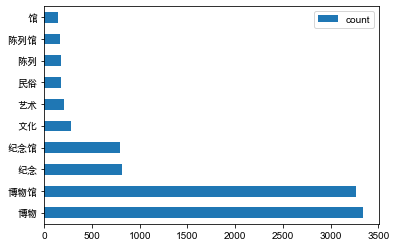

In [142]:
counts_df.sort_values(by='count', ascending=False).head(10).plot(kind='barh')

## Cleaning up the output

I don't like the fact that `博物` and `博物馆` are both in there, and the same thing with `纪念` and `纪念馆`. **This is because we used `cut_all=True`,** so we could make it stop by just... not doing that.

Instead, let's make things a little more complicated: let's create a list of words we don't like and make them all excluded.

In [174]:
# This includes empty string and a space (third line)
stopwords = """
纪念
博物
 
""".split("\n")
print(stopwords)

['', '纪念', '博物', ' ', '']


In [175]:
words = jieba.lcut(museum_names, cut_all=True)
words = [word for word in words if word not in stopwords]

counts = Counter(words)
counts.most_common(20)

[('博物馆', 3268),
 ('纪念馆', 796),
 ('文化', 283),
 ('艺术', 212),
 ('民俗', 179),
 ('陈列', 178),
 ('陈列馆', 164),
 ('馆', 141),
 ('州市', 136),
 ('革命', 135),
 ('历史', 96),
 ('故居', 94),
 ('中国', 89),
 ('旧址', 89),
 ('上海', 88),
 ('遗址', 82),
 ('民族', 74),
 ('烈士', 66),
 ('大学', 64),
 ('自治', 62)]

If we didn't want to do that, we could also get rid of the `cut_all=True` to have bigger segments with no repetition.

In [176]:
words = jieba.lcut(museum_names)
words = [word for word in words if word not in stopwords]

counts = Counter(words)
counts.most_common(20)

[('博物馆', 3190),
 ('纪念馆', 781),
 ('文化', 231),
 ('陈列馆', 164),
 ('民俗', 159),
 ('艺术', 143),
 ('革命', 108),
 ('馆', 105),
 ('故居', 90),
 ('旧址', 89),
 ('遗址', 81),
 ('上海', 72),
 ('民族', 62),
 ('中国', 61),
 ('历史', 51),
 ('成都', 48),
 ('艺术馆', 46),
 ('北京', 45),
 ('陶瓷', 41),
 ('武汉', 41)]

## Review

In this section we looked at a real-life example of using word segmentation and counting with jieba, reproducing [a piece from Caixin](https://datanews.caixin.com/mobile/museum/). We played around with two different ways of segmenting text using jieba - `cut_all` being `True` or not - and saw that while we get a lot more results with `cut_all` turned on, it might not be appropriate for all situations.

## Discussion topics

We relied on jieba for word segmentation, but it didn't necessarily give the expected results. For example, `中国国家博物馆` probably makes the most sense as `中国`/`国家`/`博物馆`, but the only options with jieba were `中国`/`国家博物馆 `or `中国`/`国家`/`博物`/`博物馆`. Do we feel comfortable with output that isn't necessarily what a human being would pick?

We used a list of stopwords at the end to prevent words we "didn't like" from showing up in the results. Is this unfair to the computer's work, or biasing our results?

One way to do this without jieba would be to print out the list of museum names and manually add spaces everywhere that we think makes sense. Then we could use `museum_names.split(' ')` to separate them. This approach would probably take us about 1 second each, plus breaks for being tired. With around 4500 museums, we'd finish in under two hours. Would it be worth it for a more accurate word segmentation?